<h1>Appendix B</h1>
<h2>ENSF 611 Winter 2020 - Final Project - Kaggle Competition</h2>
<h2><a href="https://www.kaggle.com/c/titanic/overview">Titanic: Machine Learning from Disaster</a></h2>
<h3>Kush Bhatt - Michael Lee - Matthew Vanderwey</h3>

# Introduction
<img a src="https://titanicfacts.net/wp-content/uploads/2018/06/titanic-boarding-pass.gif" data-src="https://titanicfacts.net/wp-content/uploads/2018/06/titanic-boarding-pass.gif" alt="Titanic boarding pass" width="250" height="200" hspace="10" vspace="10" align="left">The RMS Titanic was marketed by its owner's, the White Star Line, as unsinkable.  However, at approximately 20 minutes before midnight on 14 April 1912 the ship struck an iceberg that would result in its sinking just a few hours later. More than 1,500 people perished in what was the greatest maritime disaster to date.  This represented almost 2 out of every 3 people on board [1].</a>
<p>The goal of this machine learning competition, hosted by Kaggle, is to see if we can use what little information is known about each passenger to predict their survival.  For this competition Kaggle provides a training set of 891 passengers and a test set of 418 passengers, roughly a 32% test-split.  The data includes limited information about each passenger like their name, age, gender, passenger class, etc.  
<p>Before setting up our machine learning model, we will first explore the available data and see what patterns of survival (if any) can be established.  This process is known as Exploratory Data Analysis, or EDA, and it will help us review the overall quality of the data.  Including which data points are missing and which features may, or may not, be useful or not in our modeling. We will then investigate how to impute any missing values in the features we want to use, re-factor the training data, and even engineer some new features to make it easier for our models to predict survival.
<P>A cursory review of the work done by past competitors shows promise in the use of Extreme Gradient Boosting (XGBoost) [2] and ensemble [3] based models.  Therefore we will look at the application of both forms of modelling in our investigation.  We will also look at the application of the Receiver Operator Characteristic (ROC) metric [4] and precision recall curves in evaluating the performance of our models.

# Exploratory Data Analysis

## Importing Standard Libraries
The primary libraries required for our analysis include: numpy, pandas matplotlib and seaborn.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Import Raw Data
Our analysis all begins with importing the data as provided by Kaggle.  This includes a training data set (which includes whether a passenger survived or not, 1 or 0) and a testing data set, which does not included the 'Survived' label.  Also included in the data sets from Kaggle is an example of how our competition submissions should be formatted.   

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
example_submission = pd.read_csv("gender_submission.csv")

We want to analyze the passengers as one population, so will build a "master" DataFrame that includes all the passengers

In [3]:
master = pd.concat([train, test], axis=0).reset_index(drop=True)

The features (Column) of our master DataFrame and their data types (Dtype) include:

In [4]:
master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


## Exploring the Provided Features
Before we engage in any feature engineering or machine learning we need to explore both the patterns of survival and its correlations with the provided features.  We will start with looking at the split between those who survived and those who did not.

In [5]:
# Not included in final report
# plt.figure(dpi=100)
# sns.set_style('whitegrid')
# sns.countplot(x='Survived',data=master)
# plt.title('Figure 2.1 - Surivival of the Training Passengers')
# #plt.savefig("Figure 2.1.png")

In [6]:
survival_rate = sum(train['Survived'] / len(train)) * 100
print(f"The percentage of passgengers in the training data who survived is: {survival_rate:0.1f}%")

The percentage of passgengers in the training data who survived is: 38.4%


It appears that tragically a substantial majority of the passengers did not survive.  This agrees with the historical data which tells us that only 31.6% of the passengers and crew survived [5].

One of the root causes that made this such a tragedy was that fact that there were simply not enough lifeboats on the ship for everyone to escape in.  At the time the number of lifeboats that a ship was required to carry was based on its gross tonnage and not the number of people it carried.  Thus, the Titanic was only legally required to have 20 lifeboats when it needed at least 48.  Even more tragically it is estimated that the ship could have accommodated up to 64 lifeboats, but that this was cut back for esthetic and cost reasons [6].  The crew, knowing full well that there were not enough lifeboats, would have prioritized loading women and children first.  So, for our analysis we will create a new feature called "Title" which will break the population into three categories, "woman" which will include both women and girls, "boy" for underage males and "man" for adult males.

In [7]:
master['Title'] = master.apply(lambda x: 'boy' if 'Master' in x['Name'] else 'man', axis=1)
master['Title'] = master.apply(lambda x: 'woman' if 'female' in x['Sex'] else x['Title'], axis=1)

Figure 1 below shows the survival rates for these three groups.

Text(0.5, 1.0, 'Figure 1 - Survival Rate by Title')

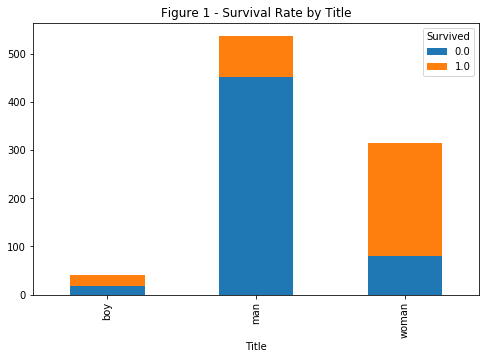

In [8]:
df_plot = master.groupby(['Survived', 'Title']).size().reset_index().pivot(columns='Survived', index='Title', values=0)
df_plot.plot(kind='bar', stacked=True, figsize=(8,5))
plt.title('Figure 1 - Survival Rate by Title')
# plt.savefig("Figure 1.png")

In [9]:
woman_boy_survival_rate = (len(master.query('PassengerId<=891 and (Title == "woman" or Title == "boy") and Survived == 1')) 
 / len(master.query('PassengerId<=891 and (Title == "woman" or Title == "boy")'))) * 100
woman_boy_survival_rate
print(f"The percentage of women and boys in the training data who survived: {woman_boy_survival_rate:0.1f}%")

The percentage of women and boys in the training data who survived: 72.3%


In [10]:
man_survival_rate = (len(master.query('PassengerId<=891 and Title == "man" and Survived == 1')) 
 / len(master.query('PassengerId<=891 and Title == "man"'))) * 100
man_survival_rate
print(f"The percentage of men in the training data who survived: {man_survival_rate:0.1f}%")

The percentage of men in the training data who survived: 16.0%


Looking at the above Figure 1 we can see that indeed most women and children surived, while the vast majority of men did not.

While 1912 may have been a chivalrous time, it was not an egalitarian one.  Even more so than it is today, back then a person's importance was measured by their wealth and and social standing. This leads us to the hypothesis that First Class passengers were more likely to survive than Second Class, and Second Class passengers were more likely to survive than Third Class.  We can easly test this hypothesis with a quick graph, shown in Figure 2 below:       

Text(0.5, 1.0, 'Figure 2 - Survival by Passenger Class')

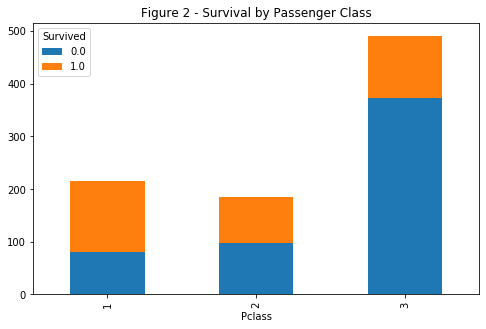

In [11]:
df_plot = master.groupby(['Survived', 'Pclass']).size().reset_index().pivot(columns='Survived', index='Pclass', values=0)
df_plot.plot(kind='bar', stacked=True, figsize=(8,5))
plt.title('Figure 2 - Survival by Passenger Class')
# plt.savefig("Figure 2.png")

In [12]:
first_survival_rate = (len(master.query('PassengerId<=891 and Pclass == 1 and Survived == 1')) 
 / len(master.query('PassengerId<=891 and Pclass == 1'))) * 100
print(f"The percentage of First-Class passengers in the training data who survived: {first_survival_rate:0.1f}%")

The percentage of First-Class passengers in the training data who survived: 63.0%


In [13]:
second_survival_rate = (len(master.query('PassengerId<=891 and Pclass == 2 and Survived == 1')) 
 / len(master.query('PassengerId<=891 and Pclass == 2'))) * 100
print(f"The percentage of Second-Class passengers in the training data who survived: {second_survival_rate:0.1f}%")

The percentage of Second-Class passengers in the training data who survived: 47.3%


In [14]:
third_survival_rate = (len(master.query('PassengerId<=891 and Pclass == 3 and Survived == 1')) 
 / len(master.query('PassengerId<=891 and Pclass == 3'))) * 100
print(f"The percentage of Second-Class passengers in the training data who survived: {third_survival_rate:0.1f}%")

The percentage of Second-Class passengers in the training data who survived: 24.2%


It appears that Figure 2 supports our hypothesis and shows that the the majority of First Class (Pclass == 1) passengers survived, roughly 50% of Second Class (Pclass == 2) passengers survived, and the majority of Third Class (Pclass == 3) passengers perished.  

The dataset provided by Kaggle includes two categorical features that may be able to yield some insights into the composition of the groups traveling together on the ship.  These features are 'SibSp' and 'Parch'.  'SibSp' represents the number of siblings and/or spouse that an individual was traveling with, and 'Parch' represents the number of parents and/or children that a passenger was traveling with.  If we add these two features together, plus 1, we get the number of members in each family that were traveling together.  Again, knowing that there were not enough lifeboats on the Titanic, and assuming that families would be reluctant to split up, we can reasonably hypothesize that large families would be less likely to survive.  We can test this hypothesis by first calculating the size of each family and plotting that against survival.

In [15]:
master['FamilySize'] = master['SibSp'] + master['Parch'] + 1

Text(0.5, 1, 'Figure 3 - Family Size and Survival')

<Figure size 1152x576 with 0 Axes>

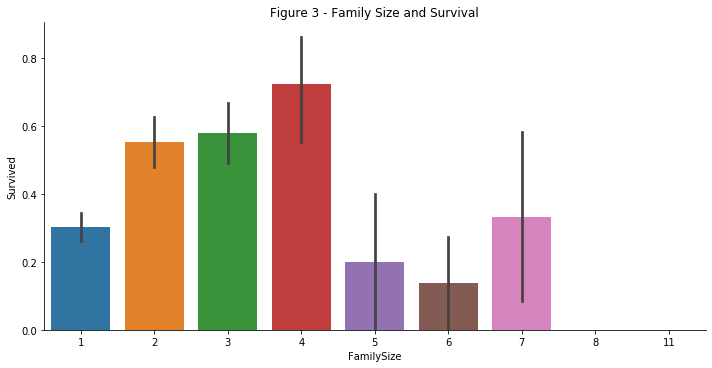

In [16]:
plt.figure(figsize=(16,8))
sns.catplot(x='FamilySize', y='Survived', data=master, kind='bar', aspect=2)
plt.title('Figure 3 - Family Size and Survival')
# plt.savefig("Figure 3.png")

Figure 3 above shows us that families with between 2 to 4 members were by far the most likely to survive.  Those travelling on their own, or in families of 5 or more, were substantially less likely to survive.  

The last categorical feature that we investigated is the point of Embarkation, 'Embarked'.  Passengers onboard the Titanic that fateful night had boarded at either, Cherbourg 'C', Queenstown 'Q', or Southampton 'S'.  While it is likely more coincidence than anything else, we should still review the relationship between Embarked and Survived.

Text(0.5, 1.0, 'Figure 4 - Survival by Point of Embarkation')

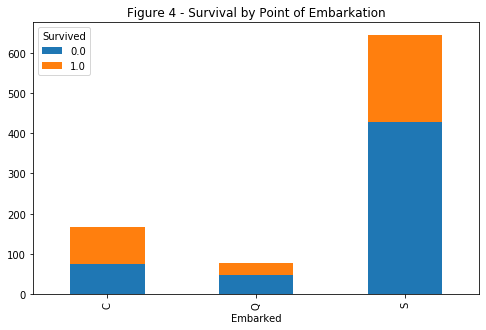

In [17]:
df_plot = master.groupby(['Survived', 'Embarked']).size().reset_index().pivot(columns='Survived', index='Embarked', values=0)
df_plot.plot(kind='bar', stacked=True, figsize=(8,5))
plt.title('Figure 4 - Survival by Point of Embarkation')
# plt.savefig("Figure 2.4.png")

In [18]:
C_rate = (len(master.query('PassengerId<=891 and Embarked == "C"')) 
 / len(master.query('PassengerId<=891'))) * 100
print(f"The percentage of passengers in the training data who embarked at Cherbourg: {C_rate:0.1f}%")

C_survival_rate = (len(master.query('PassengerId<=891 and Embarked == "C" and Survived == 1')) 
 / len(master.query('PassengerId<=891 and Embarked == "C"'))) * 100
print(f"The percentage of Cherbourg passengers in the training data who survived: {C_survival_rate:0.1f}%")

The percentage of passengers in the training data who embarked at Cherbourg: 18.9%
The percentage of Cherbourg passengers in the training data who survived: 55.4%


In [19]:
Q_rate = (len(master.query('PassengerId<=891 and Embarked == "Q"')) 
 / len(master.query('PassengerId<=891'))) * 100
print(f"The percentage of passengers in the training data who embarked at Queenstown: {Q_rate:0.1f}%")

Q_survival_rate = (len(master.query('PassengerId<=891 and Embarked == "Q" and Survived == 1')) 
 / len(master.query('PassengerId<=891 and Embarked == "Q"'))) * 100
print(f"The percentage of Queenstown passengers in the training data who survived: {Q_survival_rate:0.1f}%")

The percentage of passengers in the training data who embarked at Queenstown: 8.6%
The percentage of Queenstown passengers in the training data who survived: 39.0%


In [20]:
S_rate = (len(master.query('PassengerId<=891 and Embarked == "S"')) 
 / len(master.query('PassengerId<=891'))) * 100
print(f"The percentage of passengers in the training data who embarked at Southampton: {S_rate:0.1f}%")

S_survival_rate = (len(master.query('PassengerId<=891 and Embarked == "S" and Survived == 1')) 
 / len(master.query('PassengerId<=891 and Embarked == "S"'))) * 100
print(f"The percentage of Southampton passengers in the training data who survived: {S_survival_rate:0.1f}%")

The percentage of passengers in the training data who embarked at Southampton: 72.3%
The percentage of Southampton passengers in the training data who survived: 33.7%


It does appear that passengers who embarked at Southampton were more likely to perish.  However, this is deceptive as vast majority of passengers embarked at this port.  With such a grossly uneven distribution there is no way to make a meaningful conclusion regarding the relationship between embarkation and survival. Therefore, we will leave this feature out of our later modeling.     

Now that we have investigated the relationships between the categorical data and survival, it is time to look at the correlation between our continuous numerical features and survival.  Namely Age and Fare.  However, before we do this we need to address the fact that the values for Fare are per ticket and not per passenger. For example, The Taussig family were all traveling under Ticket No. 110413, but they did not each pay 79.650, but instead that was the cost for the entire family.  

In [21]:
# Table 1
master.loc[master['Ticket'] == '110413']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize
262,263,0.0,1,"Taussig, Mr. Emil",male,52.0,1,1,110413,79.65,E67,S,man,3
558,559,1.0,1,"Taussig, Mrs. Emil (Tillie Mandelbaum)",female,39.0,1,1,110413,79.65,E67,S,woman,3
585,586,1.0,1,"Taussig, Miss. Ruth",female,18.0,0,2,110413,79.65,E68,S,woman,3


So, before we do any analysis using the 'Fare' values we need to first standardize this value on a per-person basis by dividing the Fare by the number of people on each ticket. We will call the number of people on each ticket the 'PartySize' and the adjusted per-person fares 'FareAdj'.

In [22]:
master['PartySize'] = master['Ticket'].value_counts()[master.loc[:,'Ticket']].values

In [23]:
master['FareAdj'] = master['Fare'] / master['PartySize']

We can now use a heatmap to plot the correlation between Survival, Age and FareAdj.

Text(0.5, 1, 'Figure 5 - Survival, Age and Fare')

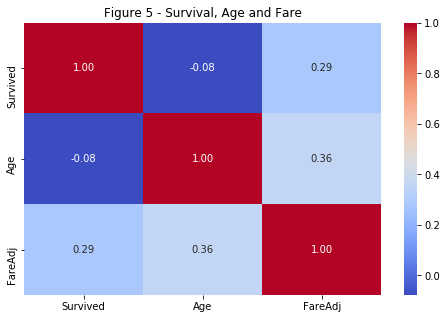

In [24]:
plt.figure(figsize=(8,5))
sns.heatmap(master[['Survived', 'Age', 'FareAdj']].corr(), annot=True, fmt='0.2f', cmap='coolwarm')
plt.title('Figure 5 - Survival, Age and Fare')
#  plt.savefig("Figure 5.png")

Looking at Figure 5 we can see that there is little, but some, correlation between Age and Survival.  There is also a marginal correlation between Fare and Survival. Let us look into this a little deeper and review the distributions of ages and fares for those who survived versus those who did not. 

Text(0.5, 1.0, 'Figure 6 - Distribution of Ages')

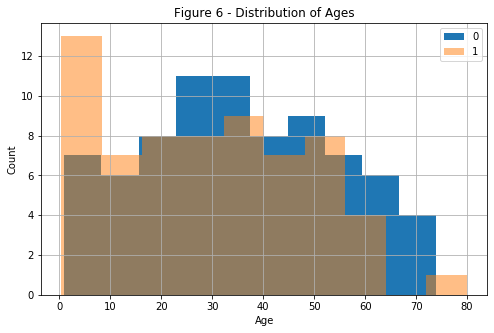

In [25]:
plot_df = master.groupby(['Survived', 'Age']).size().reset_index()
plot_df.loc[plot_df['Survived'] == 0]['Age'].hist(bins=10, figsize=(8,5))
plot_df.loc[plot_df['Survived'] == 1]['Age'].hist(bins=10, figsize=(8,5), alpha=0.5)
plt.legend(['0','1'])
plt.xlabel("Age")
plt.ylabel("Count")
plt.title('Figure 6 - Distribution of Ages')
# plt.savefig("Figure 6.png")

Text(0.5, 1.0, 'Figure 7 - Distribution of Fares')

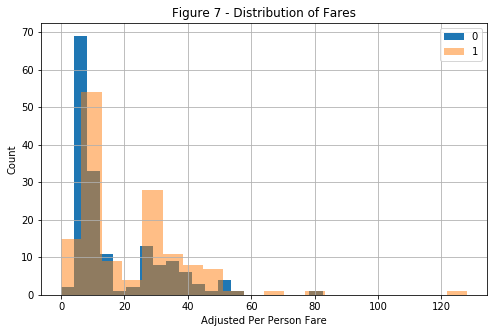

In [26]:
plot_df = master.groupby(['Survived', 'FareAdj']).size().reset_index()
plot_df.loc[plot_df['Survived'] == 0]['FareAdj'].hist(bins=20, figsize=(8,5))
plot_df.loc[plot_df['Survived'] == 1]['FareAdj'].hist(bins=20, figsize=(8,5), alpha=0.5)
plt.legend(['0','1'])
plt.xlabel("Adjusted Per Person Fare")
plt.ylabel("Count")
plt.title('Figure 7 - Distribution of Fares')
# plt.savefig("Figure 7.png")

Figure 6 above shows us that there is a substantial difference in survival for those under 15 years old.  Figure 7 shows us that those who paid under 15 for their ticket were more likely to perish and those whose paid around 25-30 were more likely to survive.  

## What We Have Learned So Far
So far, our EDA helped us make the following determinations regarding survival:
* Primary Factors:
    * Adult males were the least likely group to survive
    * Women and children were the most likely groups to survive
* Secondary Factors:
    * Passenger class and the size a family traveling together were significant factors in survival
    * Age and the per-person fare paid were moderate factors in survival
* Features we can ignore:
    * There are simple not enough data-points for cabins to make any meaningful determination with them - Over 77% of the values are missing
    * The poor distribution of embarkation points makes this feature also unsuitable for our analysis
    
The above determinations are important because they tell us that if we can find adult males who survived, and conversely women and children who perished, we will be well on our way to being able to make accurate predictions regarding survival in general.  We have also demonstrated that we can use passenger class, family size, per-person fare and age to help us find these groups of rare individuals.    

This will form the basis of the feature engineering and machine learning which we will apply in the following sections.  However, before we move forward we need to first look at imputing missing values in the provided dataset.  

## What Data Is Missing?
In this section we will review what data points are missing in our master DataFrame. We will do this with some quick statistics.  Later we will look at how to impute the missing data points. We start with calculating the number of null values in each feature.

In [27]:
master.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
Title             0
FamilySize        0
PartySize         0
FareAdj           1
dtype: int64

The above summary tells us how many values from each feature we are missing.  Because we have already decided that Cabin and Embarked are not important to our analysis, we will just look at imputing the missing Age and Fare values.

## Inputing Missing Age and Fare Values
To impute the missing values we will use a Decision Tree Regressor (DTR) as it should be a more accurate method than simply taking average values. Starting with imputing the missing ages, we will use the 'Title' feature which we engineered earlier along with 'Pclass', 'SibSp' and 'Parch' to train our DTR.  First split we split our master DataFrame into one with age values, which will be out DTR training data, and one without which will be our DTR test data.  We will then use 'dummies' to one-hot encode both the training and test data before we fit our DTR and make our age predictions. 

In [28]:
all_ages = master.loc[master['Age'] > 0].copy()
no_ages = master.loc[pd.isnull(master['Age'])].copy()

In [29]:
X_train = pd.get_dummies(all_ages[['Title', 'Pclass', 'SibSp', 'Parch']])
y_train = all_ages['Age']
X_test = pd.get_dummies(no_ages[['Title', 'Pclass', 'SibSp', 'Parch']])

In [30]:
from sklearn.tree import DecisionTreeRegressor

In [31]:
dtr = DecisionTreeRegressor()

In [32]:
dtr.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [33]:
missing_ages = pd.DataFrame(dtr.predict(X_test), index=X_test.index, columns=['Age'])

In [34]:
master['Age'] = master['Age'].combine_first(missing_ages['Age'])

Before we move on let us double-check that we have imputed our age values correctly by checking the number of null values in our master DataFrame

In [35]:
master.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
Title             0
FamilySize        0
PartySize         0
FareAdj           1
dtype: int64

We will repeat this process again for the missing fares.

In [36]:
all_fares = master.loc[master['Fare'] > 0].copy()
no_fares = master.loc[pd.isnull(master['Fare'])].copy()

In [37]:
X_train = pd.get_dummies(all_fares[['Title', 'Pclass', 'Embarked']])
y_train = all_fares['Fare']
X_test = pd.get_dummies(no_fares[['Title', 'Pclass', 'Embarked']])

In [38]:
X_test = X_test.reindex(columns=X_train.columns)
X_test = X_test.fillna(0)

In [39]:
dtr = DecisionTreeRegressor()

In [40]:
dtr.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [41]:
missing_fares = pd.DataFrame(dtr.predict(X_test), index=X_test.index, columns=['Fare'])

In [42]:
master['Fare'] = master['Fare'].combine_first(missing_fares['Fare'])

Since we were missing a 'Fare' value we also have a missing 'FareAdj' value.  We will just re-calculate all the 'FareAdj' values to address this quickly.

In [43]:
master['FareAdj'] = master['Fare'] / master['PartySize']

Let's see how we are doing for missing values now.

In [44]:
master.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          2
Title             0
FamilySize        0
PartySize         0
FareAdj           0
dtype: int64

We have now sucessfully imputed all of the missing values that we need for our analysis and modelling. 

# Finding the Surviving Men

## Isolating A Training Set
The first rare group that we are going to look for are the surviving adult males.  The first step towards doing this is to create a new training dataset for men only.  

In [45]:
X_men = master[(master['PassengerId'] <= 891) & (master['Title'] == 'man')]

Next we will generate some Kernel Density Estimation (KDE) plots to look at the distributions of 'Age', 'FareAdj', 'FamilySize' and 'Pclass' in this trainging data.   

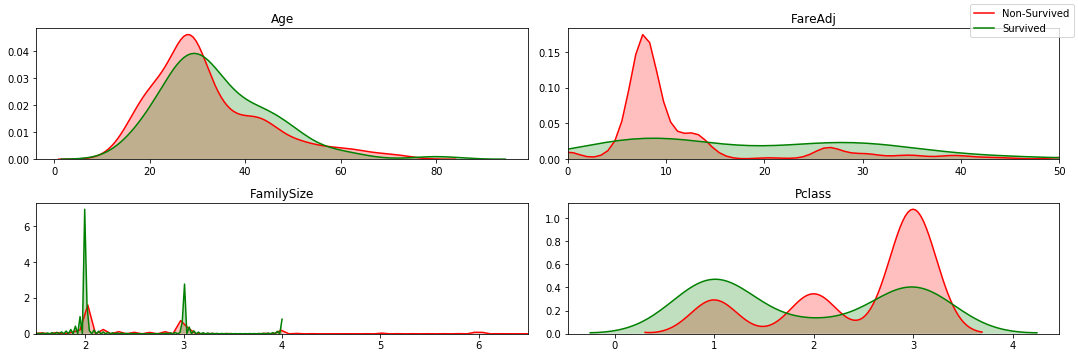

In [46]:
fig, axes = plt.subplots(2,2, figsize=(15,5))
sns.kdeplot(X_men.loc[X_men['Survived']==0.0]['Age'], shade=True, color='r', ax=axes[0,0], legend=False)
sns.kdeplot(X_men.loc[X_men['Survived']==1.0]['Age'], shade=True, color='g', ax=axes[0,0], legend=False)
axes[0,0].set_title('Age')
sns.kdeplot(X_men.loc[X_men['Survived']==0.0]['FareAdj'], shade=True, color='r', ax=axes[0,1], legend=False)
sns.kdeplot(X_men.loc[X_men['Survived']==1.0]['FareAdj'], shade=True, color='g', ax=axes[0,1], legend=False)
axes[0,1].set_title('FareAdj')
axes[0,1].set_xlim(0,50)
sns.kdeplot(X_men.loc[X_men['Survived']==0.0]['FamilySize'], shade=True, color='r', ax=axes[1,0], bw=0, legend=False)
sns.kdeplot(X_men.loc[X_men['Survived']==1.0]['FamilySize'], shade=True, color='g', ax=axes[1,0], bw=0, legend=False)
axes[1,0].set_title('FamilySize')
axes[1,0].set_xlim(1.5,6.5)
sns.kdeplot(X_men.loc[X_men['Survived']==0.0]['Pclass'], shade=True, color='r', ax=axes[1,1], legend=False)
sns.kdeplot(X_men.loc[X_men['Survived']==1.0]['Pclass'], shade=True, color='g', ax=axes[1,1], legend=False)
axes[1,1].set_title('Pclass')
fig.legend(['Non-Survived','Survived'])
fig.tight_layout()
# plt.savefig("Figure 8.png")

The above plots tell us that we are most likely to find surviving men at Age == 40, FareAdj == 20, FamilySize == 2 and Pclass == 1.

To find patterns where all these features intersect, we must reduce them down to two dimensions. This will make it possible to plot their relationships in 2D.

## Finding Patterns of Survival

In [47]:
y = X_men['Survived']
x1 = X_men['FareAdj']/10
x2 = (X_men['FamilySize'])+(X_men['Age']/70)
Pclass = X_men['Pclass']
X_men_2feats = pd.concat([y.astype(int),x1,x2,Pclass], axis=1)
X_men_2feats.columns = ['Survived', 'x1', 'x2', 'Pclass']

In [48]:
X_men_2feats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 537 entries, 0 to 890
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  537 non-null    int32  
 1   x1        537 non-null    float64
 2   x2        537 non-null    float64
 3   Pclass    537 non-null    int64  
dtypes: float64(2), int32(1), int64(1)
memory usage: 18.9 KB


We choose to only review FareAdj/10 (x1) vs. FamilySize+Age/70 (x2) and ignored Pclass for now because, as we can see in Figure 4.2.1 below, there is already a strong correlation between the Adjusted Fare and Passenger Class.

Text(0.5, 0, 'x1=Adjusted Fare/10')

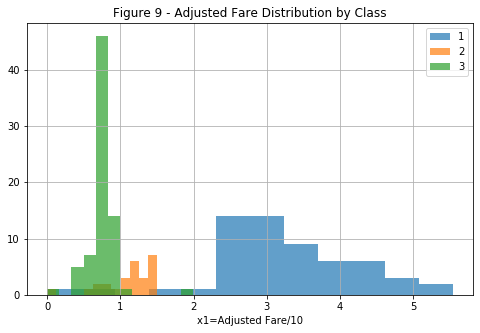

In [49]:
plt.figure(figsize=(8,5))
plt_df = X_men_2feats.query('x1<6 and x2<6').groupby(['Pclass', 'x1']).size().reset_index()
plt_df.loc[plt_df['Pclass'] == 1]['x1'].hist(bins=12, alpha=0.7)
plt_df.loc[plt_df['Pclass'] == 2]['x1'].hist(bins=12, alpha=0.7)
plt_df.loc[plt_df['Pclass'] == 3]['x1'].hist(bins=12, alpha=0.7)
plt.legend([1,2,3])
plt.title('Figure 9 - Adjusted Fare Distribution by Class')
plt.xlabel('x1=Adjusted Fare/10')
# plt.savefig("Figure 9.png")

Below we plot our new features to see if they show any patterns of survival.

Text(0.5, 1.0, 'Figure 10 - Survival Patterns of Adult Males')

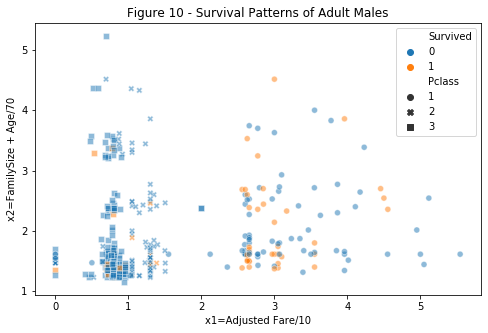

In [50]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='x1', y='x2', hue='Survived', style='Pclass', data=X_men_2feats.query('x1<6 and x2<6'), alpha=0.5)
plt.xlabel('x1=Adjusted Fare/10')
plt.ylabel('x2=FamilySize + Age/70')
plt.title('Figure 10 - Survival Patterns of Adult Males')
# plt.savefig("Figure 10.png")

By creating x2=FamilySize+Age/70 we can view the SibSp, Parch and Age features all in one dimension.  Creating x1=Adjusted Fare/10 allows us to see the impact of individual ticket costs on a similar scale as 'x2'.  Looking at the above we see a cluster of surviving men around x2<=2.5 (Family Size <= 2 + Age < 35 ) and 2.5<x1<3.5 (per person fare of 25 to 35) which would put those passengers in First Class.

## Can XGBoost Find Patterns Of Surviving Men?
In this section we will start with fitting an XGBoost (Extreme Gradient Boosted Trees) model to our men-only training data and then generate a set of 10,000 predictions over a series of linear vectors to plot the results.  This should enable us see if the model is able to find patterns of survival with our training data.  

In [51]:
x1s = np.linspace(0,5,100)
x2s = np.linspace(1,3,100)

In [52]:
x1 = np.repeat(x1s, 100)
x2 = [j for i in range(100) for j in x2s]

In [53]:
g = pd.DataFrame([x1,x2]).T
g.columns = ['x1','x2']

In [54]:
from xgboost import XGBClassifier

In [55]:
xgb = XGBClassifier(objective='binary:logistic', max_depth=5, learning_rate=0.1, gamma=0.1, colsample_bytree=1, min_child_weight=1)

In [56]:
history = xgb.fit(X_men_2feats[['x1','x2']], X_men_2feats['Survived'], eval_metric='error')

In [57]:
pred = xgb.predict(g[['x1','x2']])

In [58]:
print(f'The predicted survival rate for adult males is only {(sum(pred)/10000)*100}%, so they are going to be hard to find!')

The predicted survival rate for adult males is only 9.07%, so they are going to be hard to find!


In [59]:
g['Survived'] = pred

## Visualization of Our Prediction Model

The light colours in the background below are the grid predictions and the darker coloured points are the actual values from the training data.

Text(0.5, 1.0, 'Figure 11 - XGBoost Predicted Patterns of Adult Male Survival')

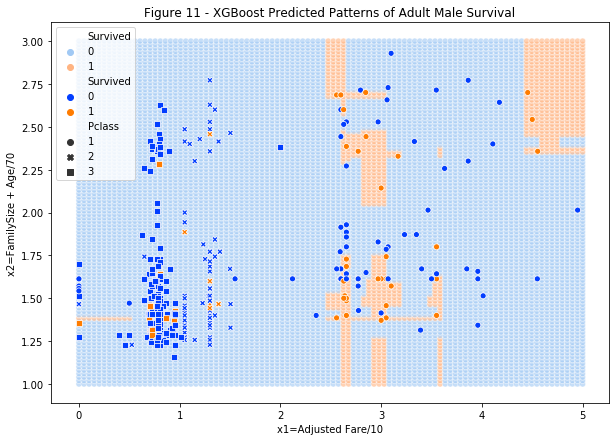

In [60]:
plt.figure(figsize=(10,7))
sns.scatterplot(x='x1', y='x2', hue='Survived', palette='pastel', data=g, alpha=0.6)
sns.scatterplot(x='x1', y='x2', style='Pclass', hue='Survived', palette='bright',data=X_men_2feats.query('x1<5 and x2<3'))
plt.legend()
plt.xlabel('x1=Adjusted Fare/10')
plt.ylabel('x2=FamilySize + Age/70')
plt.title('Figure 11 - XGBoost Predicted Patterns of Adult Male Survival')
# plt.savefig("Figure 11.png")

Looking at the above plot we see that our XGBoost model has determined that the men most likely to survive were from First Class (Pclass 1), paid ~28 for their ticket, had 2 or fewer people in their family on board and were under 30. This aligns with our earlier evaluations and gives us confidence in our model.  Unfortunately, it does appear that our model is unlikely to find any survivors outside of First Class. 

## Receiver Operator Characteristic (ROC) and Area Under the Curve (AUC)

In order to tune our model a little further, we are going to evaluate the quality of the classifier output using the Receiver Operator Characteristic (ROC) metric and measure the Area Under the Curve (AUC). We will use these metrics to tune the hyperparameters of max_depth and the probability threshold [4].

In [61]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_men_2feats[['x1','x2']], X_men_2feats['Survived'], test_size=.3, random_state=42)

We rebuilt the XGBoost classifier several times and determined that a max depth of 5 gave us the greatest area under the curve, i.e. the highest rate of True Positives vs. False Positives. 

In [62]:
xgb = XGBClassifier(objective='binary:logistic', max_depth=5, learning_rate=0.1, gamma=0.1, colsample_bytree=1, min_child_weight=1)

In [63]:
history = xgb.fit(X_train, y_train, eval_metric='error')

In [64]:
y_score = xgb.predict_proba(X_test)[:,1]

In [65]:
from sklearn.metrics import roc_curve, auc, accuracy_score, average_precision_score, precision_recall_curve, plot_precision_recall_curve, classification_report

In [66]:
# Calculate the False Positive Rate and True Positive Rate
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

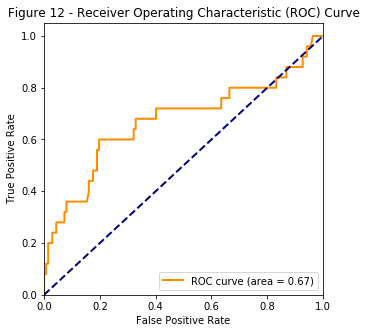

In [67]:
plt.figure(figsize=(5,5))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Figure 12 - Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
# plt.savefig("Figure 12.png")

Figure 12 shows us that we may be able to produce better results by using a higher probability threshold than simply 50%.  This is because the curve is a little steeper in the bottom left, so in the next section we will see if we can improve our accuracies using a higher probability threshold.

The accuracy score for our initial 50% threshold:

In [68]:
y_pred = np.array(list(map(lambda x: 1 if x>0.50 else 0, y_score)))
# print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       137
           1       0.41      0.28      0.33        25

    accuracy                           0.83       162
   macro avg       0.64      0.60      0.62       162
weighted avg       0.80      0.83      0.81       162



Now a 75% threshold:

In [69]:
y_pred = np.array(list(map(lambda x: 1 if x>0.75 else 0, y_score)))
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       137
           1       0.75      0.12      0.21        25

    accuracy                           0.86       162
   macro avg       0.81      0.56      0.56       162
weighted avg       0.84      0.86      0.81       162



Looking better, but let's try 90%:

In [70]:
y_pred = np.array(list(map(lambda x: 1 if x>0.90 else 0, y_score)))
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       137
           1       1.00      0.04      0.08        25

    accuracy                           0.85       162
   macro avg       0.93      0.52      0.50       162
weighted avg       0.87      0.85      0.79       162



Is 92% a bridge too far?

In [71]:
y_pred = np.array(list(map(lambda x: 1 if x>0.92 else 0, y_score)))
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       137
           1       0.00      0.00      0.00        25

    accuracy                           0.85       162
   macro avg       0.42      0.50      0.46       162
weighted avg       0.72      0.85      0.77       162



C:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


It appears that 90% is our sweet spot for a probability threshold

## Precision and Recall Performance of Our Model
Since looking for a surviving adult male is like finding the perverbial needle in a haystack, the precision and recall scores are actually more important than pure accuracy.

In [72]:
average_precision = average_precision_score(y_test, y_score)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 0.41


Text(0.5, 1.0, 'Figure 13 - 2-class Precision-Recall curve: AP=0.41')

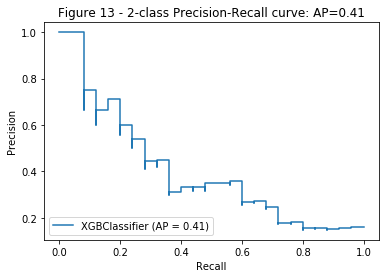

In [73]:
disp = plot_precision_recall_curve(xgb, X_test, y_test)
disp.ax_.set_title('Figure 13 - 2-class Precision-Recall curve: ''AP={0:0.2f}'.format(average_precision))
# disp.ax_

Figure 13 indicates that our model is not likely to identify many survivors (low recall), but those that it does, are very likely actual survivors (high precision).  

## Testing our XGBoost Model Using Cross Validation

In this section we will test our model by checking its cross-validation scores.

In [74]:
from sklearn.model_selection import cross_val_score

In [75]:
scores = cross_val_score(xgb, X_men_2feats[['x1','x2']], X_men_2feats['Survived'], cv=10)

In [76]:
print("Scores: ")
print(scores)

Scores: 
[0.7962963  0.77777778 0.81481481 0.81481481 0.81481481 0.81481481
 0.87037037 0.8490566  0.8490566  0.8490566 ]


In [77]:
print(f'Mean cross validation score: {scores.mean()*100:0.2f}%')

Mean cross validation score: 82.51%


82.51% is a reasonable score, so we will go ahead and prepare our final predictions on the testing data.

## Extracting Training and Testing Data for Male Survivors

Now we will spilt out master dataset into a training and test set, both aligned with the original data sets provided by Kaggle.

In [78]:
dataB = master[(master['PassengerId'] <= 891) & (master['Title'] == 'man')]
dataC = master[(master['PassengerId'] > 891) & (master['Title'] == 'man')]

In [79]:
dataTrain = pd.concat([dataB['Survived'].astype(int), dataB['FareAdj']/10, dataB['FamilySize']+(dataB['Age']/70)], axis=1)
dataTrain.columns=['Survived', 'x1', 'x2']

In [80]:
dataTest = pd.concat([dataC['Survived'], dataC['FareAdj']/10, dataC['FamilySize']+(dataC['Age']/70), dataC['PassengerId']], axis=1)
dataTest.columns=['Survived', 'x1', 'x2', 'PassengerId']

## Fitting The XGBoost Model To The Test Data

In [81]:
xgb = XGBClassifier(objective='binary:logistic', max_depth=4, learning_rate=0.1, gamma=0.1, colsample_bytree=1, min_child_weight=1)

In [82]:
history = xgb.fit(dataTrain[['x1','x2']], dataTrain['Survived'], eval_metric='error')

In [83]:
y_score = xgb.predict_proba(dataTest[['x1','x2']])[:,1]

In [84]:
y_pred = pd.DataFrame(np.array(list(map(lambda x: 1 if x>0.90 else 0, y_score))), index=dataTest.index)
y_pred.columns=['Survived']

The total number of surviving adult males found by our XGBoost classifier is:

In [85]:
sum(y_pred['Survived'])

0

So our super-dooper model has predicted that none of the men in the test data will survive. This was initially a frustrating finding, however this agrees with the findings of some of the highest ranking models completed for this competition to date.  This includes the famous Titanic Megal Model [7].

# Women and Children Groups

Accepting the tragic findings from the previous section and moving on, we will now focus on finding what we will call Women and Children Groups (WCGs).  In section 2 we identified these groups as the ones most likely to survive.  Thus, we should be able to make fairly accurate predictions based on the assumption that all of these individuals survive with the exception of a few rare members.  Our challenge now is to find these rare members of our WCGs.  We will do this based on the following hypothesis:  
* All boys survive in families where all the females and other boys survive
* All females perish in families where all the boys and other females perish

## Engineering Woman-Child-Groups (WCG)
To build our family groups we first start with extracting everyone's family name.

In [86]:
master['Surname'] = master['Name'].apply(lambda x: x.split(',')[0])

Next we create group id's based on Surname, Pclass, Ticket, Fare and Embarked.

In [87]:
import re

In [88]:
master['TicketX'] = master['Ticket'].apply(lambda x: re.sub('.$', 'X', x))

In [89]:
x = master[['Surname', 'Pclass', 'TicketX', 'Fare', 'Embarked']].to_string(header=False, index=False, index_names=False).split('\n')
vals = ['-'.join(i.split()) for i in x]

In [90]:
master['GroupId'] = vals

Since we demonstrated that it was most accurate to assume that all adult males perish, we will lump them into one group.

In [91]:
master.loc[master['Title'] == 'man', 'GroupId'] = 'NoGroup'

We quickly check that we do not have any null values in our GroupIds:

In [92]:
master['GroupId'].isnull().sum()

0

## Meet the Wilkes-Richards-Hocking Family
Before we move on, there is a documented anomoly in the data regarding the Wilkes-Richards-Hocking family.  We need to address this otherwise this large family will be split into three groups when they were in fact travelling together as one [8].

In [93]:
master.loc[master['Name'].apply(lambda x: 'Needs' in x)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,PartySize,FareAdj,Surname,TicketX,GroupId
774,775,1.0,2,"Hocking, Mrs. Elizabeth (Eliza Needs)",female,54.0,1,3,29105,23.0,NaN,S,woman,5,2,11.5,Hocking,2910X,Hocking-2-2910X-23.00000-S
892,893,NaN,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0,NaN,S,woman,2,1,7.0,Wilkes,36327X,Wilkes-3-36327X-7.00000-S


In [94]:
master.loc[892, 'GroupId'] = master.loc[774, 'GroupId']

In [95]:
master.loc[master.GroupId=='Richards-2-2910X-18.75000-S','GroupId'] = 'Hocking-2-2910X-23.00000-S'

In [96]:
master.loc[529,'GroupId'] = 'Hocking-2-2910X-23.00000-S'

In [97]:
master.loc[master.GroupId=='Hocking-2-2910X-23.00000-S']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,PartySize,FareAdj,Surname,TicketX,GroupId
407,408,1.0,2,"Richards, Master. William Rowe",male,3.00,1,1,29106,18.75,NaN,S,boy,3,3,6.25,Richards,2910X,Hocking-2-2910X-23.00000-S
437,438,1.0,2,"Richards, Mrs. Sidney (Emily Hocking)",female,24.00,2,3,29106,18.75,NaN,S,woman,6,3,6.25,Richards,2910X,Hocking-2-2910X-23.00000-S
529,530,0.0,2,"Hocking, Mr. Richard George",male,23.00,2,1,29104,11.50,NaN,S,man,4,1,11.50,Hocking,2910X,Hocking-2-2910X-23.00000-S
774,775,1.0,2,"Hocking, Mrs. Elizabeth (Eliza Needs)",female,54.00,1,3,29105,23.00,NaN,S,woman,5,2,11.50,Hocking,2910X,Hocking-2-2910X-23.00000-S
831,832,1.0,2,"Richards, Master. George Sibley",male,0.83,1,1,29106,18.75,NaN,S,boy,3,3,6.25,Richards,2910X,Hocking-2-2910X-23.00000-S
892,893,NaN,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.00,1,0,363272,7.00,NaN,S,woman,2,1,7.00,Wilkes,36327X,Hocking-2-2910X-23.00000-S
943,944,NaN,2,"Hocking, Miss. Ellen Nellie""""",female,20.00,2,1,29105,23.00,NaN,S,woman,4,2,11.50,Hocking,2910X,Hocking-2-2910X-23.00000-S


## WCG Final Engineering
We can now compute the number of members in each group.

In [98]:
master['GroupFreq'] = master['GroupId'].value_counts()[master.loc[:,'GroupId']].values

In [99]:
master.loc[master['GroupFreq'] == 1, 'GroupId'] = 'NoGroup'

In [100]:
master['GroupFreq'] = master['GroupId'].value_counts()[master.loc[:,'GroupId']].values

Let's check how many WCG's are there so far:

In [101]:
master['GroupId'].nunique()-1 # We don't count NoGroup

79

Next we will try to find the nanny's and other relatives that travelled together but had different ticket numbers. We can do this by creating a new features called TicketId, which is a concatenation of Ticket, Pclass, Fare and Embarked.

In [102]:
x = master[['Pclass', 'TicketX', 'Fare', 'Embarked']].to_string(header=False, index=False, index_names=False).split('\n')
master['TicketId'] = ['-'.join(i.split()) for i in x]

In [103]:
idx = master.query('Title != "man" and GroupId == "NoGroup"').index

In [104]:
print("Current number of single women and boys: ", len(idx))

Current number of single women and boys:  307


In [105]:
for i in idx:
    z = master['GroupId'][master['TicketId'] == master['TicketId'][i]]
    q = [j for j in z if j != "NoGroup"]
    if len(q) > 0:
        master.loc[i,'GroupId'] = q[0]

In [106]:
print("Number of nannies and other female relatives found and added to their repsective families: ",
      len(idx) - len(master.query('Title != "man" and GroupId == "NoGroup"').index) )

Number of nannies and other female relatives found and added to their repsective families:  11


Now Let's calcualte the group survival rates:

In [107]:
master['GroupSurvival'] = master.groupby('GroupId')['Survived'].mean()[master.loc[:,'GroupId']].values

In [108]:
master['GroupSurvival'].value_counts()

0.337875    1077
1.000000     129
0.000000      76
0.800000       7
0.750000       6
0.500000       5
Name: GroupSurvival, dtype: int64

How many WCG's have we missed?

In [109]:
master.query('GroupSurvival == "NaN"')['Name'].count()

9

We will sssume that any ungrouped third class passengers perished.

In [110]:
idx = master.query('GroupSurvival == "NaN" and Pclass == 3').index
master.loc[idx, 'GroupSurvival'] = 0

We will also assume that any ungrouped first class passengers survived.

In [111]:
idx = master.query('GroupSurvival == "NaN" and Pclass == 1').index
master.loc[idx, 'GroupSurvival'] = 1

In [112]:
master['GroupSurvival'].value_counts()

0.337875    1077
1.000000     131
0.000000      83
0.800000       7
0.750000       6
0.500000       5
Name: GroupSurvival, dtype: int64

Tragically we can see above that there were 83 entire families/groups that all perished together.  

## Getting Ready to Make Our First Kaggle Submission
Based on our extensive EDA in Section 2.0 and the results of Seciont 3.0, we will start with the base predictions that:
* All males perish
* All females survive

Then, we will refine this with the assumptions that:
* No women survived if their group did not survive
* Boys survived if the rest of their family did

In [113]:
master['Predict'] = 0 

In [114]:
master.loc[master.Sex =="female", 'Predict'] = 1

In [115]:
idx = master.query('Title == "woman" and GroupSurvival == 0').index
master.loc[idx, 'Predict'] = 0

In [116]:
idx = master.query('Title == "boy" and GroupSurvival == 1').index
master.loc[idx, 'Predict'] = 1

Here is our list of boys predicted to live:

In [117]:
master.query('Sex == "male" and Predict == 1 and PassengerId > 891')['Name']

955         Ryerson, Master. John Borie
980         Wells, Master. Ralph Lester
1052     Touma, Master. Georges Youssef
1085      Drew, Master. Marshall Brines
1087    Spedden, Master. Robert Douglas
1198          Aks, Master. Philip Frank
1283      Abbott, Master. Eugene Joseph
1308           Peter, Master. Michael J
Name: Name, dtype: object

Here is our list of women Predicted to perish:

In [118]:
master.query('Sex == "female" and Predict == 0 and PassengerId > 891')['Name']

909                          Ilmakangas, Miss. Ida Livija
924     Johnston, Mrs. Andrew G (Elizabeth Lily" Watson)"
928                                    Cacic, Miss. Manda
1023                        Lefebre, Mrs. Frank (Frances)
1031                          Goodwin, Miss. Jessie Allis
1044       Klasen, Mrs. (Hulda Kristina Eugenia Lofqvist)
1050                  Peacock, Mrs. Benjamin (Edith Nile)
1079                                      Sage, Miss. Ada
1140            Khalil, Mrs. Betros (Zahie Maria" Elias)"
1154                         Klasen, Miss. Gertrud Emilia
1171                               Oreskovic, Miss. Jelka
1175                          Rosblom, Miss. Salli Helena
1256                       Sage, Mrs. John (Annie Bullen)
1258         Riihivouri, Miss. Susanna Juhantytar Sanni""
1300                            Peacock, Miss. Treasteall
Name: Name, dtype: object

Create our submission

In [119]:
submission = master.loc[891:, ['PassengerId', 'Predict']]

In [120]:
submission.reset_index(drop=True, inplace=True)

In [121]:
submission.rename(columns={'Predict':'Survived'}, inplace=True)

In [122]:
#submission.to_csv('2020-03-30_WCG.csv', index=False)

## First Results
The result of our first submission is 0.83732 which indicates that we are on the right track, but there is likely much improvement to be made.  In the next section we will look at the other rare group of individuals to find, and that is of single women who perished in the disaster. 

# All the Single Ladies

## Single Women of Indeterminate Survival
In this section we will use an ensemble method to identify single women who do not surive.  First we will generate a couple of DataFrames which contain a subset of the master training and testing data, but only for women who were not part of groups either entirely perished or entirely survived.

In [123]:
# Groups in the training data who either all survived or all perished
WCGtrain = master.query('PassengerId<=891 and (GroupSurvival==0 or GroupSurvival==1)')
# Groups in test data who either all survived or all perished
WCGtest = master.query('PassengerId>891 and (GroupSurvival==0 or GroupSurvival==1)')

In [124]:
# Single Women in the trainign set
dataB = master.query('PassengerId<=891 and Title=="woman" and FamilySize==1')
# Single Women in the test set
dataC = master.query('PassengerId>891 and Title=="woman" and FamilySize==1')

In [125]:
# Drop women from the test set who belonged to groups that either entirely survived or entirely perished
Cset = set(dataC.index)
WCGset = set(WCGtest.index)
drop_list = list(Cset & WCGset)
#drop_list
dataC.drop(drop_list, inplace=True, axis=0)

C:\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [126]:
y = dataB['Survived']
x1 = dataB['FareAdj']/10
x2 = dataB['Age']/15
PassId = dataB['PassengerId']
Pclass = dataB['Pclass']
dataTrain = pd.concat([y,x1,x2,PassId,Pclass], axis=1)
dataTrain.columns=['Survived', 'x1','x2','PassengerId','Pclass']

In [127]:
y = dataC['Survived']
x1 = dataC['FareAdj']/10
x2 = dataC['Age']/15
PassId = dataC['PassengerId']
Pclass = dataC['Pclass']
dataTest = pd.concat([y,x1,x2,PassId,Pclass], axis=1)
dataTest.columns=['Survived', 'x1','x2','PassengerId','Pclass']

## Using an Ensemble to Find the Lost Ladies
We have decided to use an ensemble consisting of the following models:
* Logistic Regression
* Random Forest Classifier
* Support Vector Machines Classifier (SVC)
* Decision Tree Classifier 
* K-Nearest Neighbours

In [128]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [129]:
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = SVC(probability=True, random_state=1)
clf4 = DecisionTreeClassifier(max_depth=2)
clf5 = KNeighborsClassifier(n_neighbors=3)

In [130]:
eclf_hard = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('svc', clf3), ('dtc', clf4), ('knn', clf5)], voting='hard', weights=[0.6,0.6,0.6,0.9,1])

In [131]:
eclf_soft = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('svc', clf3), ('dtc', clf4), ('knn', clf5)], voting='soft', weights=[0.6,0.6,0.6,0.9,1])

In [132]:
classifiers = ['Logistic Regression', 'Random Forest', 'SVM', 'DecisionTree', 'KNN', 'HardVoteEnsemble', 'SoftVoteEnsemble']

We will check the quality of our ensemble model by checking the cross-validation scores and then use these scores to tune the weights applied to the votes for each model.

In [133]:
print('\n5-fold cross validation:')
for clf, label in zip([clf1, clf2, clf3, clf4, clf5, eclf_hard, eclf_soft], classifiers):
    scores = model_selection.cross_val_score(clf, dataTrain[['x1','x2','Pclass']], dataTrain['Survived'], cv=5, scoring='accuracy')
    print(f"\tAccuracy: {scores.mean():0.2f} [{label}]")


5-fold cross validation:
	Accuracy: 0.78 [Logistic Regression]
	Accuracy: 0.79 [Random Forest]
	Accuracy: 0.79 [SVM]
	Accuracy: 0.83 [DecisionTree]
	Accuracy: 0.83 [KNN]
	Accuracy: 0.83 [HardVoteEnsemble]
	Accuracy: 0.82 [SoftVoteEnsemble]


After tuning the voting weights, the above cross-validation scores appear acceptable.  Because we want to be able to also tune the probability threshold for our predictions, we will use the soft voting ensemble to make our predictions.

In [134]:
eclf_soft.fit(dataTrain[['x1','x2','Pclass']], dataTrain['Survived'])

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=1, solver='lbfgs',
                                                 tol=0.0001, verbose=0,
                                                 warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                

In [135]:
y_score = eclf_soft.predict_proba(dataTest[['x1','x2','Pclass']])[:,1]

In [136]:
# Apply a threshold function to tune the predictions 
y_pred = pd.DataFrame(np.array(list(map(lambda x: 0 if x<=0.30 else 1, y_score))), index=dataTest.index)
y_pred.columns=['Survived']

## Preparing Our Second Submission to Kaggle
We will now try to improve on our performance in Section 5 by updating the survival predictions for single women based on the results of our ensemble.

In [137]:
dataTest['Survived'] = y_pred['Survived']

In [138]:
fatal_idx = dataTest.loc[dataTest.Survived == 0].index

In [139]:
master2 = master.copy()

In [140]:
master2.loc[fatal_idx,'Predict'] = 0

In [141]:
fatal_ids = master2.loc[fatal_idx,'PassengerId'].values

In [142]:
submission2 = submission.copy()

In [143]:
submission2.loc[submission2['PassengerId'].isin(fatal_ids)]

,PassengerId,Survived
36,928,1
199,1091,1
268,1160,1


In [144]:
submission2.loc[submission2['PassengerId'].isin(fatal_ids),'Survived'] = 0

In [145]:
#submission2.to_csv('2020-03-28_Ensemble.csv', index=False)

Our prediction score is now = 0.84210 and this is as far as we we will go for this report.  We did also complete an exercise in MS Excel were we cross-referenced several predictions (including those published by other competitors), and were able to get our score up to 85.65%.  However, this was more an exercise in spreadsheet manipulation than machine learning, so we consider it outside the scope of this project.    

<img src="./Kaggle_Score.png">

After completing almost 50 submissions, it is also clear that Kaggle does not score the submissions using all of the data points.  This is determination based on the fact that submissions with 10-20 different predictions would all recieve the same score.  The score appears to be based on a select group within the test data.  If you are fortunate to predict the survival of these select individuals correctly, your score will go up.  

# Conclusions
At the end of our journey, while we were able to obtain a top 200 score (out of 17,000+ teams) the actual use of machine learning itself to get there was limited.  In fact, we could have likely achieved a score over 0.80 using purely feature engineering and basic statistics.  As noted earlier, we are confident that the key to this competition is identifying the Women and Children Groups.  Knowing that there are likely more groups such as the Wilkes-Richards-Hocking family in the dataset, further review of the data is likely to yield even more accurate WCGs than what we did here.  From there, if we had more time, we would experiment with various ensembles for revising our predictions for both surviving adult males and single women who perished.   Possibly using an ensemble of XGBoost, KNN and DTC as these seemed to perform best.  This makes sense because most of the provide features are either categorical or of discrete numerical values.  

# References
* [1]	D. Fowler, “The History in Numbers”, titanicfacts.net. [Online]. Available: https://titanicfacts.net/. [Accessed: 30 March 2020].
* [2]	C. Deotte, “Titanic WCG+XGBoost[0.84688]”. Kaggle.com. [Online]. Available: https://www.kaggle.com/cdeotte/titanic-wcg-xgboost-0-84688. [Accessed: 30 March 2020].
* [3]	Y. Ghouzam, “Titanic Top 4% with ensemble modeling”. Kaggle.com. [Online]. Available: https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling. * [Accessed: 30 March 2020].
* [4]	Scikit-learn. “Receiver Operator Characteristic (ROC)”. Scikit-learn.org. [Online]. Available: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html. [Accessed: 30 March 2020]. 
* [5]	D. Fowler. “Titanic Survivors”. Titanicfacts.net. [Online]. Available: https://titanicfacts.net/titanic-survivors/. [Accessed: 30 March 2020].
* [6]	D. Fowler. “Titanic Lifeboats”. Titanicfacts.net. [Online]. Available: https://titanicfacts.net/titanic-survivors/. [Accessed: 30 March 2020].
* [7]	C. Deotte. “Titanic Mega Model – [0.84210]”, Kaggle.com. Sec. B.4. [Online]. Available: https://www.kaggle.com/cdeotte/titantic-mega-model-0-84210#B4.-All-Adult-Males-Die. [Accessed: 30 March 2020].
* [8]	C. Deotte. “Titanic Mega Model – [0.84210]”, Kaggle.com. Sec. B.6. [Online]. Available: https://www.kaggle.com/cdeotte/titantic-mega-model-0-84210#B6.-Meet-the-surviving-Wilkes,-Hocking,-Richards-family. [Accessed: 30 March 2020].
* [9]	D. Fowler, “Titanic Survivor List”, titanicfacts.net. [Online]. Available: https://titanicfacts.net/titanic-survivors-list/. [Accessed: 30 March 2020].
